In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, cross_validate 
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline as ImbPipeline 
import warnings
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")

In [2]:
# ==========================================
# 1. PERSIAPAN DATA (RAW) - DENGAN OUTPUT
# ==========================================
print("=== 1. INISIALISASI DATA ===")

try:
    # Load Data
    df = pd.read_csv('data.csv')
    
    # --- OUTPUT SEBELUM CLEANING ---
    print("\n--- [BEFORE] DATA MENTAH ---")
    print(f"1. Dimensi Awal      : {df.shape}")
    print(f"2. Kolom Sampah      : {'Unnamed: 32' in df.columns} (Cek keberadaan 'Unnamed: 32')")
    print(f"3. Sampel Diagnosis  : {df['diagnosis'].head(3).tolist()}")
    print(f"4. Cek Null Values   : {df.isnull().sum().sum()} (Total nilai null di seluruh df)")
    
    # ----------------------------------
    # CLEANING & PREPROCESSING
    # ----------------------------------
    
    # 1. Drop kolom tidak berguna
    # 'id' tidak punya nilai prediktif, 'Unnamed: 32' adalah artefak error
    cols_to_drop = ['id', 'Unnamed: 32']
    for col in cols_to_drop:
        if col in df.columns:
            df = df.drop(col, axis=1)

    # Pisahkan Fitur (X) dan Target (y)
    X = df.drop('diagnosis', axis=1)
    y = df['diagnosis']

    # 2. Encoding Target (Diagnosis)
    # PENTING: Ubah ke angka 0/1 agar algoritma bisa hitung AUC-ROC
    le = LabelEncoder()
    y_encoded = le.fit_transform(y) # M=1, B=0

    # 3. Imputing (Jaga-jaga jika ada missing values)
    imputer = SimpleImputer(strategy='mean')
    X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)
    
    # (Optional) Scaling hanya untuk display statistik 'After'
    # Scaling SEBENARNYA nanti dilakukan di dalam Pipeline agar tidak 'bocor'
    scaler_display = StandardScaler()
    X_scaled_display = scaler_display.fit_transform(X_imputed)

    # --- OUTPUT SESUDAH CLEANING ---
    print("\n--- [AFTER] DATA BERSIH & PREPROCESSED ---")
    print(f"1. Dimensi X Akhir   : {X_imputed.shape} (Harusnya 30 kolom fitur)")
    print(f"2. List Kolom X      : {X_imputed.columns.tolist()[:3]} ... [dan {len(X_imputed.columns)-3} lainnya]")
    print(f"3. Sampel Target (y) : {y_encoded[:5]} (M=1, B=0)")
    print(f"4. Statistik Skala   : Mean={np.mean(X_scaled_display):.4f} (Mendekati 0), Std={np.std(X_scaled_display):.4f} (Mendekati 1)")
    print(f"5. Distribusi Kelas  : {np.bincount(y_encoded)} (0=Benign, 1=Malignant)")

    print("\nData siap untuk pemodelan.")

except FileNotFoundError:
    print("Error: File 'data.csv' tidak ditemukan.")
    raise

=== 1. INISIALISASI DATA ===

--- [BEFORE] DATA MENTAH ---
1. Dimensi Awal      : (569, 33)
2. Kolom Sampah      : True (Cek keberadaan 'Unnamed: 32')
3. Sampel Diagnosis  : ['M', 'M', 'M']
4. Cek Null Values   : 569 (Total nilai null di seluruh df)

--- [AFTER] DATA BERSIH & PREPROCESSED ---
1. Dimensi X Akhir   : (569, 30) (Harusnya 30 kolom fitur)
2. List Kolom X      : ['radius_mean', 'texture_mean', 'perimeter_mean'] ... [dan 27 lainnya]
3. Sampel Target (y) : [1 1 1 1 1] (M=1, B=0)
4. Statistik Skala   : Mean=-0.0000 (Mendekati 0), Std=1.0000 (Mendekati 1)
5. Distribusi Kelas  : [357 212] (0=Benign, 1=Malignant)

Data siap untuk pemodelan.


In [3]:
# ==========================================
# 2. SKENARIO EKSPERIMEN (FIXED)
# ==========================================
resamplers = {
    "SMOTE": SMOTE(random_state=42),
    "ROS": RandomOverSampler(random_state=42),
    "SMOTE-ENN": SMOTEENN(random_state=42)
}

models = {
    "SVM": SVC(probability=True, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Naive Bayes": GaussianNB(),
    "Neural Network": MLPClassifier(max_iter=500, random_state=42)
}

# K-Values
k_values_fig4 = [5, 10, 20, 30, 37, 39, 40]
final_results_storage = []


PROSES ANALISIS METODE: SMOTE (VALID PIPELINE)
1. SMOTE: Menghitung Metrik Model (5-Fold Stratified)...


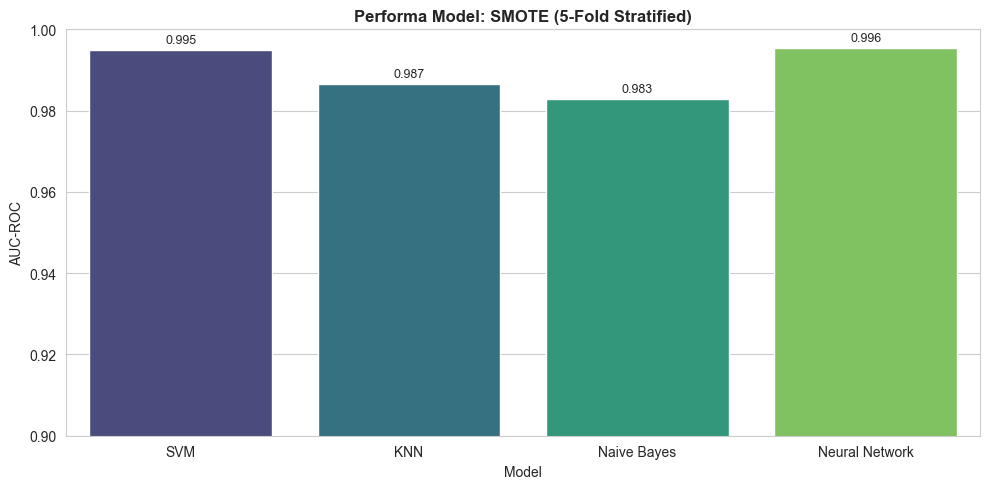

2. SMOTE: Analisis Variasi K-Fold (Pipeline)...


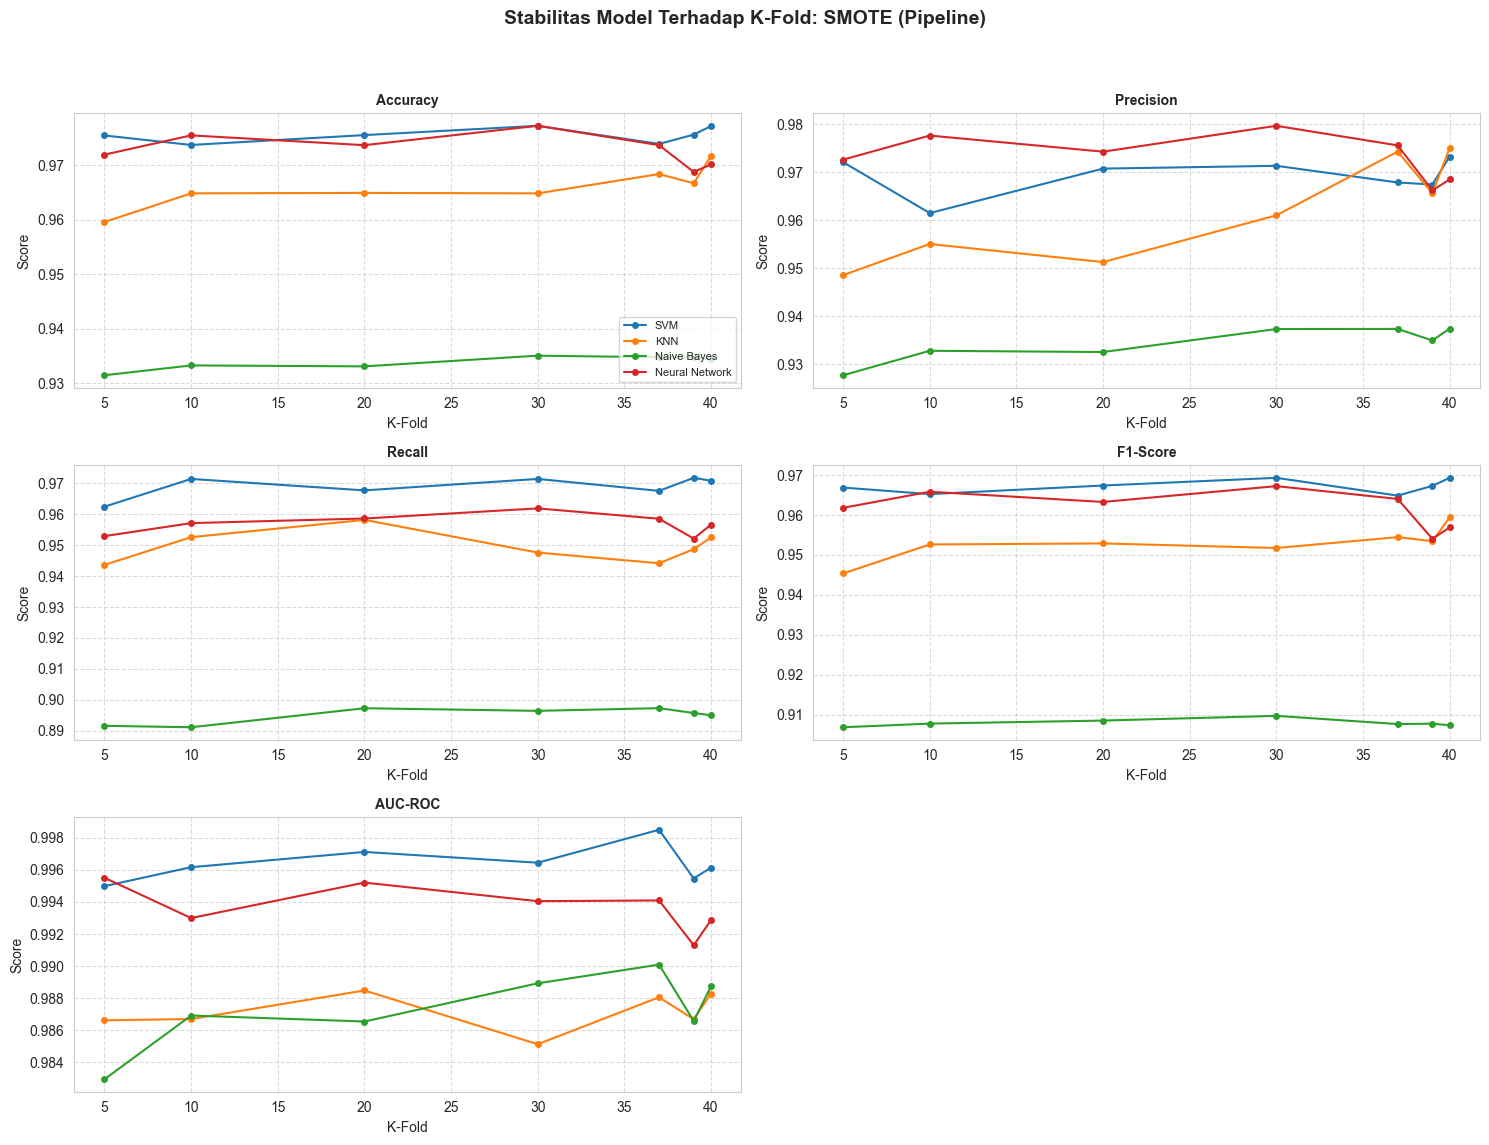


PROSES ANALISIS METODE: ROS (VALID PIPELINE)
1. ROS: Menghitung Metrik Model (5-Fold Stratified)...


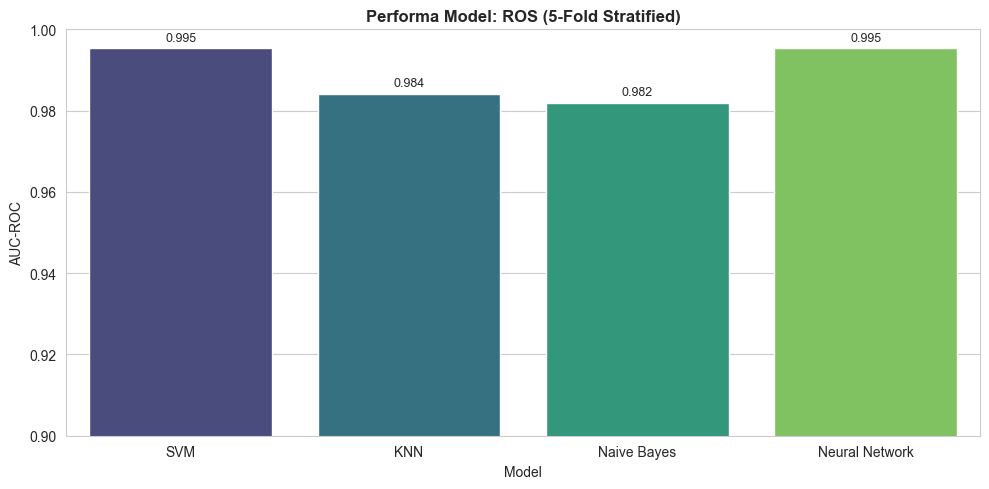

2. ROS: Analisis Variasi K-Fold (Pipeline)...


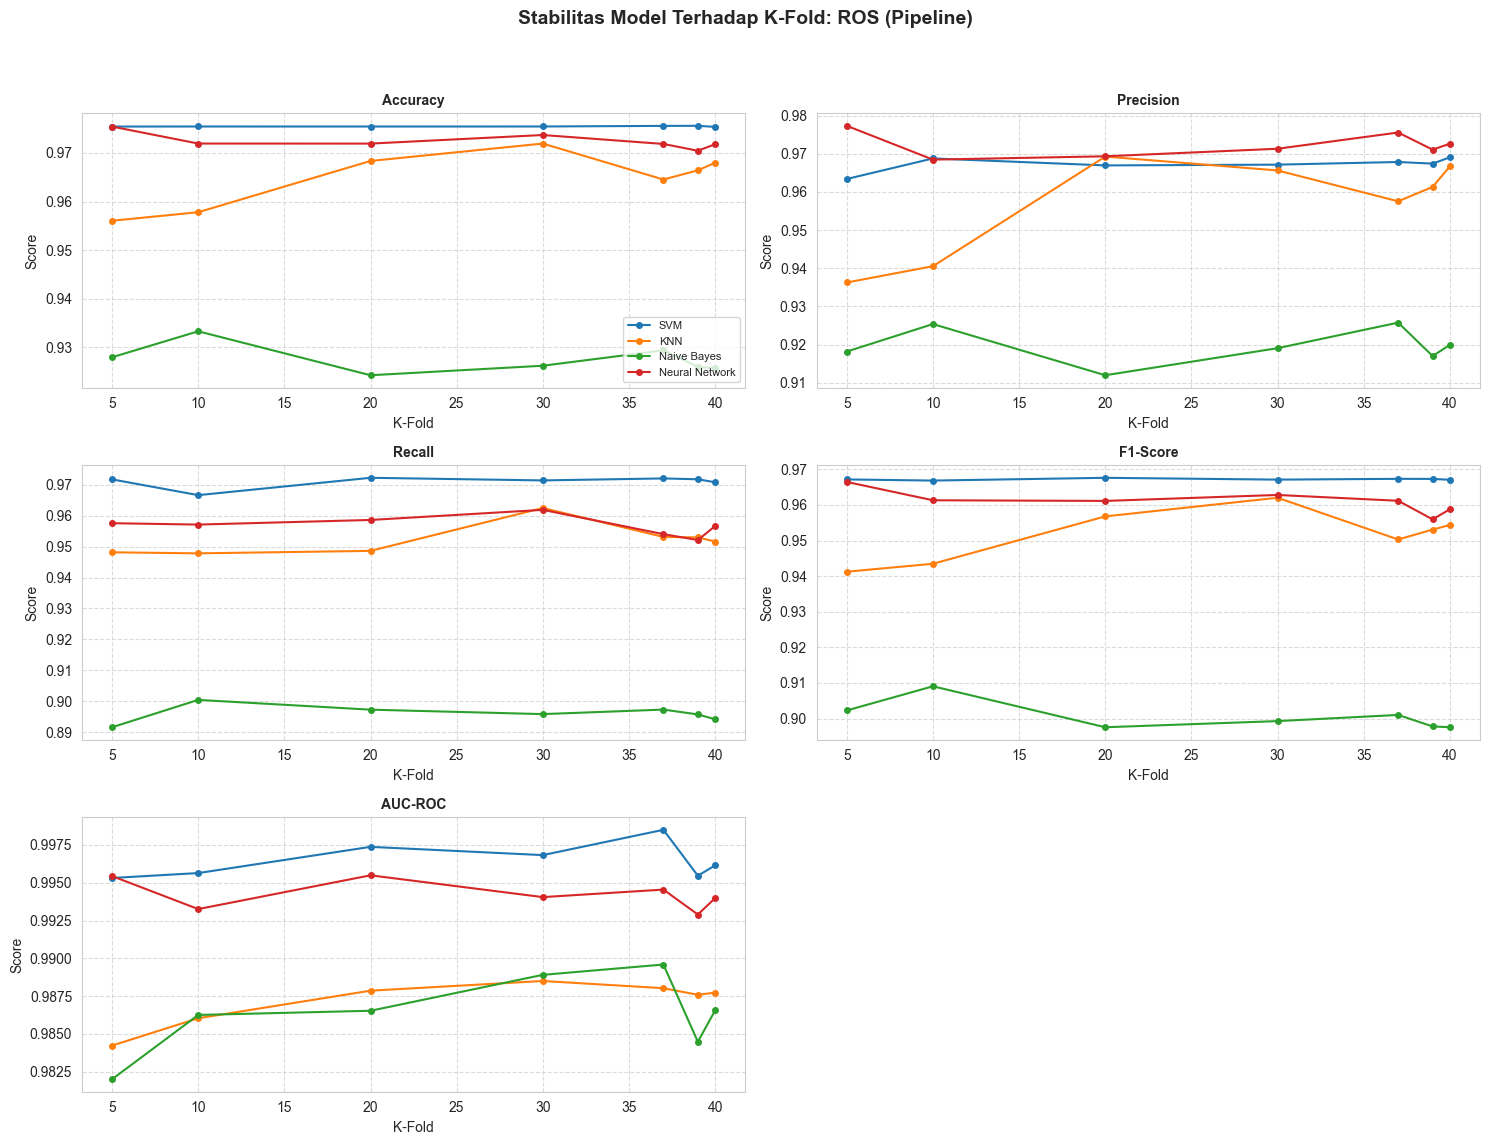


PROSES ANALISIS METODE: SMOTE-ENN (VALID PIPELINE)
1. SMOTE-ENN: Menghitung Metrik Model (5-Fold Stratified)...


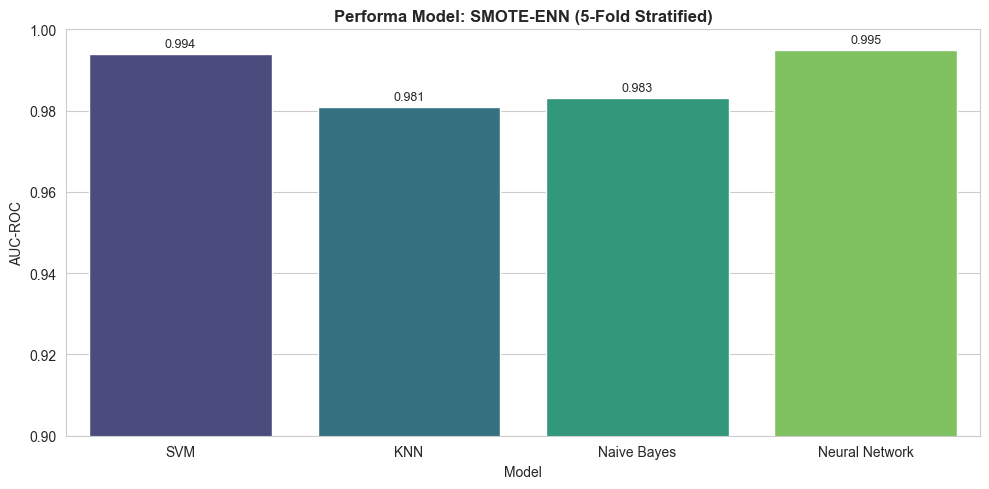

2. SMOTE-ENN: Analisis Variasi K-Fold (Pipeline)...


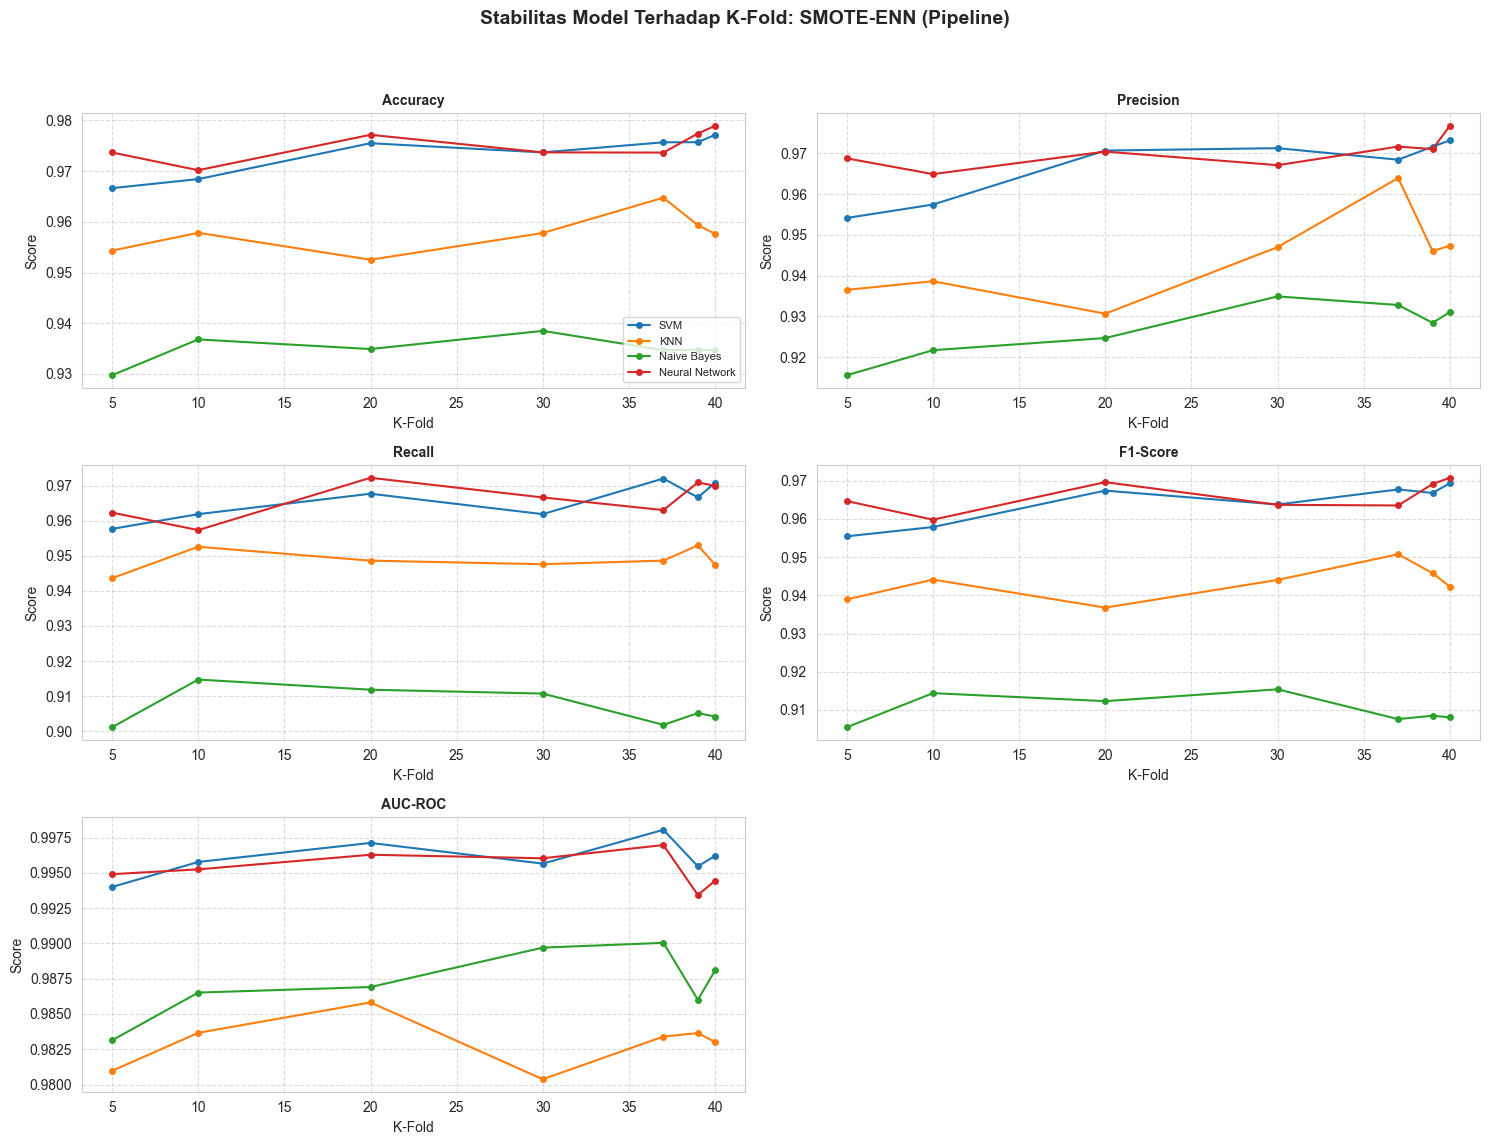

In [7]:
# ==========================================
# 3. EKSEKUSI LOOP (PIPELINE BASED)
# ==========================================

for res_name, resampler in resamplers.items():
    print(f"\n{'='*60}")
    print(f"PROSES ANALISIS METODE: {res_name} (VALID PIPELINE)")
    print(f"{'='*60}")
    
    # --- BAGIAN A: BAR CHART (5-FOLD) ---
    print(f"1. {res_name}: Menghitung Metrik Model (5-Fold Stratified)...")
    
    skf_5 = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    split_results = []
    
    for model_name, model in models.items():
        pipeline = ImbPipeline([
            ('scaler', StandardScaler()), 
            ('res', resampler), 
            ('mod', model)
        ])
        
        scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
        scores = cross_validate(pipeline, X_imputed, y_encoded, cv=skf_5, scoring=scoring, n_jobs=-1)
        
        # Simpan hasil sementara
        avg_auc = np.mean(scores['test_roc_auc'])
        split_results.append({
            "Model": model_name,
            "Accuracy": np.mean(scores['test_accuracy']),
            "AUC-ROC": avg_auc
        })
        
        # === [FIX] SIMPAN KE GLOBAL STORAGE ===
        # Ini bagian yang hilang sebelumnya
        final_results_storage.append({
            "Metode Resampling": res_name,
            "Model": model_name,
            "Skor AUC-ROC": avg_auc
        })
        
    # Visualisasi A: Bar Chart 
    df_split = pd.DataFrame(split_results)
    
    plt.figure(figsize=(10, 5))
    ax = sns.barplot(x="Model", y="AUC-ROC", data=df_split, palette="viridis")
    plt.ylim(0.90, 1.0) 
    plt.title(f"Performa Model: {res_name} (5-Fold Stratified)", fontsize=12, fontweight='bold')
    for container in ax.containers:
        ax.bar_label(container, fmt='%.3f', padding=3, fontsize=9)
    plt.tight_layout()
    plt.show()

    # --- BAGIAN B: LINE CHART (VARIASI K-FOLD) ---
    print(f"2. {res_name}: Analisis Variasi K-Fold (Pipeline)...")
    history = {m: {'acc': [], 'prec': [], 'rec': [], 'f1': [], 'auc': []} for m in models}

    for k in k_values_fig4:
        skf_k = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
        
        for model_name, model in models.items():
            pipeline = ImbPipeline([
                ('scaler', StandardScaler()), 
                ('res', resampler), 
                ('mod', model)
            ])
            
            scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
            scores = cross_validate(pipeline, X_imputed, y_encoded, cv=skf_k, scoring=scoring, n_jobs=-1)
            
            history[model_name]['acc'].append(np.mean(scores['test_accuracy']))
            history[model_name]['prec'].append(np.mean(scores['test_precision']))
            history[model_name]['rec'].append(np.mean(scores['test_recall']))
            history[model_name]['f1'].append(np.mean(scores['test_f1']))
            history[model_name]['auc'].append(np.mean(scores['test_roc_auc']))

    # Visualisasi B
    fig, axes = plt.subplots(3, 2, figsize=(15, 12))
    fig.suptitle(f'Stabilitas Model Terhadap K-Fold: {res_name} (Pipeline)', fontsize=14, fontweight='bold')
    metrics_map = [('Accuracy', 'acc', axes[0,0]), ('Precision', 'prec', axes[0,1]),
                   ('Recall', 'rec', axes[1,0]), ('F1-Score', 'f1', axes[1,1]), ('AUC-ROC', 'auc', axes[2,0])]
    fig.delaxes(axes[2, 1])

    for title, key, ax in metrics_map:
        for model_name in models.keys():
            ax.plot(k_values_fig4, history[model_name][key], marker='o', linestyle='-', label=model_name, markersize=4)
        ax.set_title(title, fontsize=10, fontweight='bold')
        ax.set_xlabel('K-Fold')
        ax.set_ylabel('Score')
        ax.grid(True, linestyle='--', alpha=0.7)
        if title == 'Accuracy': ax.legend(loc='lower right', fontsize=8) 
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


=== 4. KESIMPULAN AKHIR: PERBANDINGAN ANTAR METODE ===


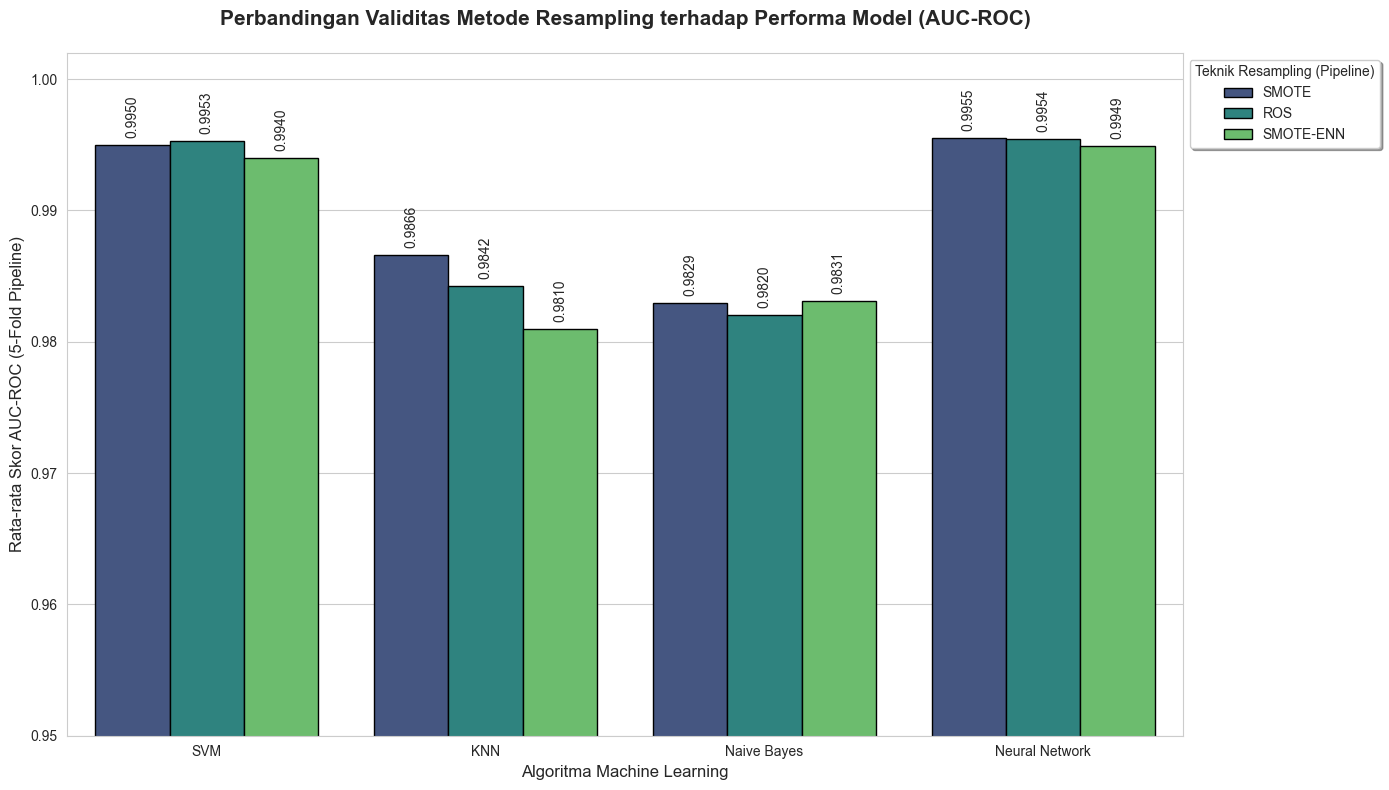


############################################################
Metodologi Terbaik:
1. Model Paling Robust: Neural Network
2. Metode Resampling:   SMOTE
3. Skor AUC-ROC Valid:  0.99551
############################################################

=== SEMUA PROSES SELESAI ===


In [8]:
# ==========================================
# 4. VISUALISASI FINAL: HEAD-TO-HEAD (VALID)
# ==========================================
print("\n" + "="*60)
print("=== 4. KESIMPULAN AKHIR: PERBANDINGAN ANTAR METODE ===")
print("="*60)

# Karena append di loop sudah diperbaiki, df_final sekarang aman
df_final = pd.DataFrame(final_results_storage)

plt.figure(figsize=(14, 8))
ax = sns.barplot(
    data=df_final,
    x="Model",
    y="Skor AUC-ROC",
    hue="Metode Resampling",
    palette="viridis",
    edgecolor="black",
    linewidth=1
)

plt.title("Perbandingan Validitas Metode Resampling terhadap Performa Model (AUC-ROC)", fontsize=15, fontweight='bold', pad=20)
plt.ylim(0.95, 1.002) 
plt.ylabel("Rata-rata Skor AUC-ROC (5-Fold Pipeline)", fontsize=12)
plt.xlabel("Algoritma Machine Learning", fontsize=12)
plt.legend(title="Teknik Resampling (Pipeline)", bbox_to_anchor=(1.0, 1), loc='upper left', frameon=True, shadow=True)

for container in ax.containers:
    ax.bar_label(container, fmt='%.4f', padding=5, fontsize=10, rotation=90)

plt.tight_layout()
plt.show()

best_row = df_final.loc[df_final['Skor AUC-ROC'].idxmax()]
print("\n" + "#"*60)
print("Metodologi Terbaik:")
print(f"1. Model Paling Robust: {best_row['Model']}")
print(f"2. Metode Resampling:   {best_row['Metode Resampling']}")
print(f"3. Skor AUC-ROC Valid:  {best_row['Skor AUC-ROC']:.5f}")
print("#"*60)

print("\n=== SEMUA PROSES SELESAI ===")